# Mobile Phone Price Prediction

This notebook includes data exploration, preprocessing, feature extraction, model building, and evaluation.

In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    

## Step 1: Load the Dataset

In [8]:

# Define file path and load dataset
df = pd.read_excel("Processed_Flipdata.xlsx")

# Display basic information
df.info()

# Display first five rows
df.head()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     541 non-null    int64  
 1   Model          541 non-null    object 
 2   Colour         541 non-null    object 
 3   Memory         541 non-null    int64  
 4   RAM            541 non-null    int64  
 5   Battery_       541 non-null    int64  
 6   Rear Camera    541 non-null    object 
 7   Front Camera   541 non-null    object 
 8   AI Lens        541 non-null    int64  
 9   Mobile Height  541 non-null    float64
 10  Processor_     541 non-null    object 
 11  Prize          541 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 50.8+ KB


,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


## Step 2: Data Exploration

In [11]:

# Display summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
    

Number of duplicate rows: 0


## Step 3: Data Preprocessing

In [16]:

# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical missing values with mode
        else:
            df[col].fillna(df[col].median(), inplace=True)  # Fill numerical missing values with median

# Handling outliers using IQR method for numerical columns only
numeric_cols = df.select_dtypes(include=['number']).columns  # Select only numeric columns
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers in numerical columns only
df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Convert categorical variables into numerical using one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Data Preprocessing Completed!")
    

Data Preprocessing Completed!


## Step 4: Feature Extraction

In [27]:
print(df.columns)

Index(['Unnamed: 0', 'Memory', 'RAM', 'Battery_', 'AI Lens', 'Mobile Height',
       'Prize', 'Model_I Kall Z19Pro Flash blue', 'Model_IQOO Neo 7 5G',
       'Model_Infinix Hot 12 Pro',
       ...
       'Processor__UNISOC T700', 'Processor__Unisoc',
       'Processor__Unisoc SC9863A/ Unisoc SC9863A1', 'Processor__Unisoc T606',
       'Processor__Unisoc T610', 'Processor__Unisoc T612',
       'Processor__Unisoc T612 processor', 'Processor__Unisoc T616',
       'Processor__Unisoc Tiger T612 (12 nm)', 'Processor__Unisoc Tiger T616'],
      dtype='object', length=376)


Index(['unnamed: 0', 'memory', 'ram', 'battery_', 'ai lens', 'mobile height',
       'prize', 'model_i kall z19pro flash blue', 'model_iqoo neo 7 5g',
       'model_infinix hot 12 pro',
       ...
       'processor__unisoc t700', 'processor__unisoc',
       'processor__unisoc sc9863a/ unisoc sc9863a1', 'processor__unisoc t606',
       'processor__unisoc t610', 'processor__unisoc t612',
       'processor__unisoc t612 processor', 'processor__unisoc t616',
       'processor__unisoc tiger t612 (12 nm)', 'processor__unisoc tiger t616'],
      dtype='object', length=376)


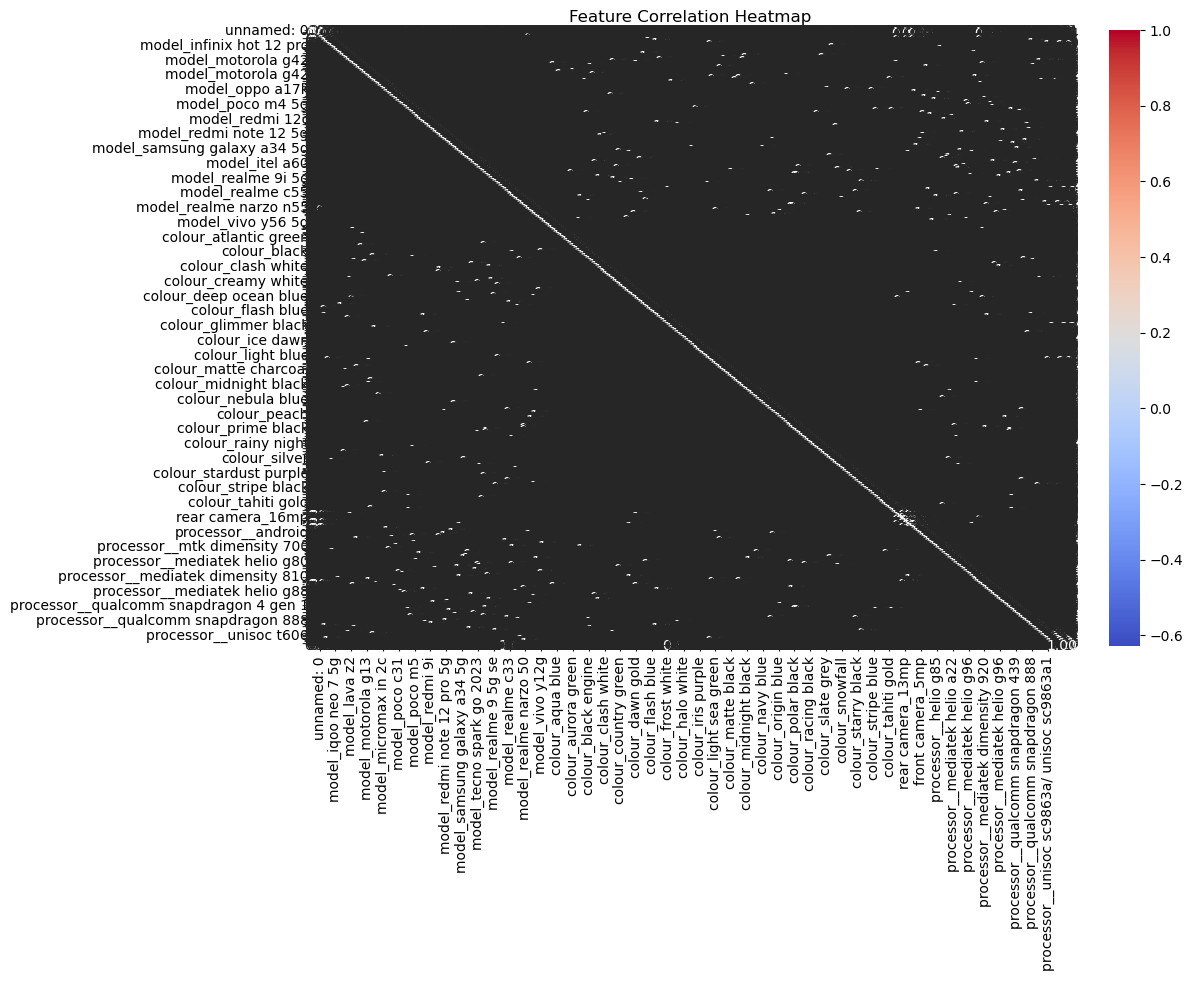

Top 10 selected features: ['memory', 'ram', 'mobile height', 'model_samsung galaxy a34 5g', 'rear camera_13mp', 'rear camera_8mp', 'front camera_16mp', 'front camera_5mp', 'processor__dimensity 1080, octa core', 'processor__mediatek helio a22']
Explained variance ratio by PCA components: [9.56328351e-01 4.35088712e-02 4.16428391e-05 1.26836990e-05
 8.17635617e-06]


In [29]:
# Standardize column names to avoid case or space issues
df.columns = df.columns.str.strip().str.lower()  # Convert column names to lowercase and remove extra spaces
print(df.columns)  # Print column names to verify

# Check and use the correct column name ('prize' instead of 'price')
if 'prize' in df.columns:
    X = df.drop(columns=['prize'])
    y = df['prize']
else:
    print("Error: 'prize' column is missing from the dataframe!")

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Select top 10 best features
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Top 10 selected features:", selected_features.tolist())

# Apply PCA for dimensionality reduction
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)


## Step 5: Model Building

In [32]:

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
feature_importances = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "Mean Absolute Error": mae,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "R-squared Score": r2
    }
    
    print(f"{name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")
    
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_
        
results_df = pd.DataFrame(results).T
results_df
    

Linear Regression Performance:
MAE: 93041265874.69485, MSE: 4.33180598799387e+22, RMSE: 208129911065.03336, R2: -1235934346240967.8
Decision Tree Performance:
MAE: 803.3529411764706, MSE: 3800073.617647059, RMSE: 1949.377751398394, R2: 0.8915777503583612
Random Forest Performance:
MAE: 1163.5097058823533, MSE: 4041996.433967646, RMSE: 2010.4716943960307, R2: 0.8846753009259841
Gradient Boosting Performance:
MAE: 1240.7546506771482, MSE: 4119379.6337749986, RMSE: 2029.6254910142902, R2: 0.8824674330129471


,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-squared Score
Linear Regression,9.304127e+10,4.331806e+22,2.081299e+11,-1.235934e+15
Decision Tree,8.033529e+02,3.800074e+06,1.949378e+03,8.915778e-01
Random Forest,1.163510e+03,4.041996e+06,2.010472e+03,8.846753e-01
Gradient Boosting,1.240755e+03,4.119380e+06,2.029625e+03,8.824674e-01


## Step 6: Feature Importance Analysis

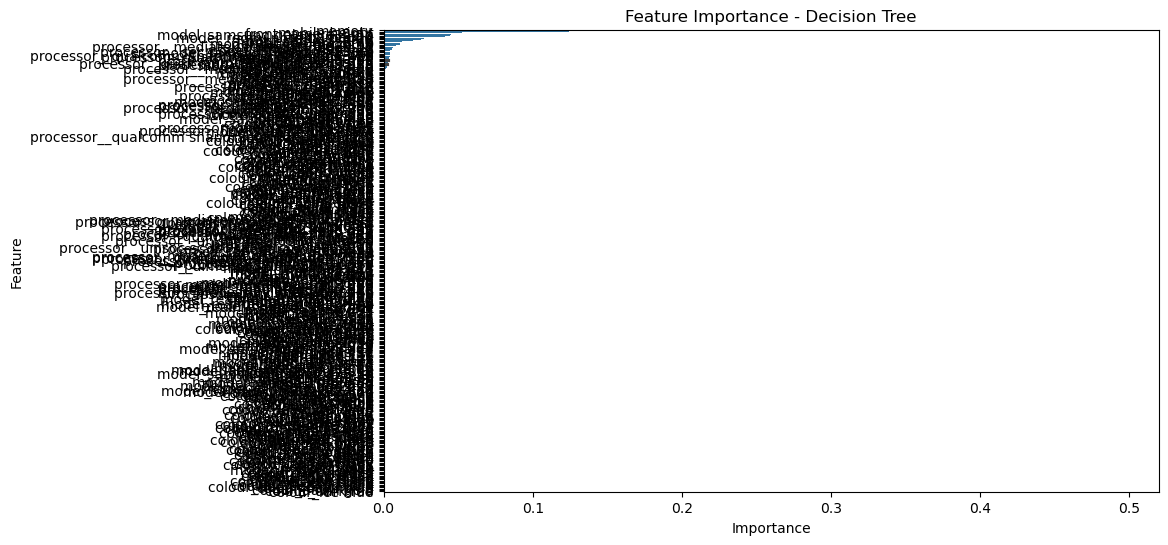

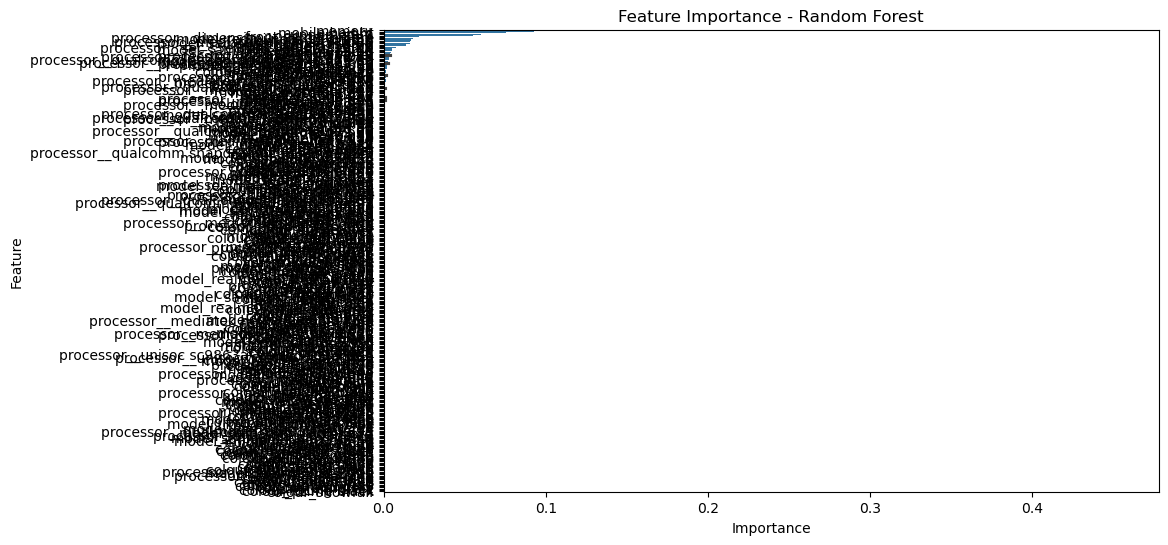

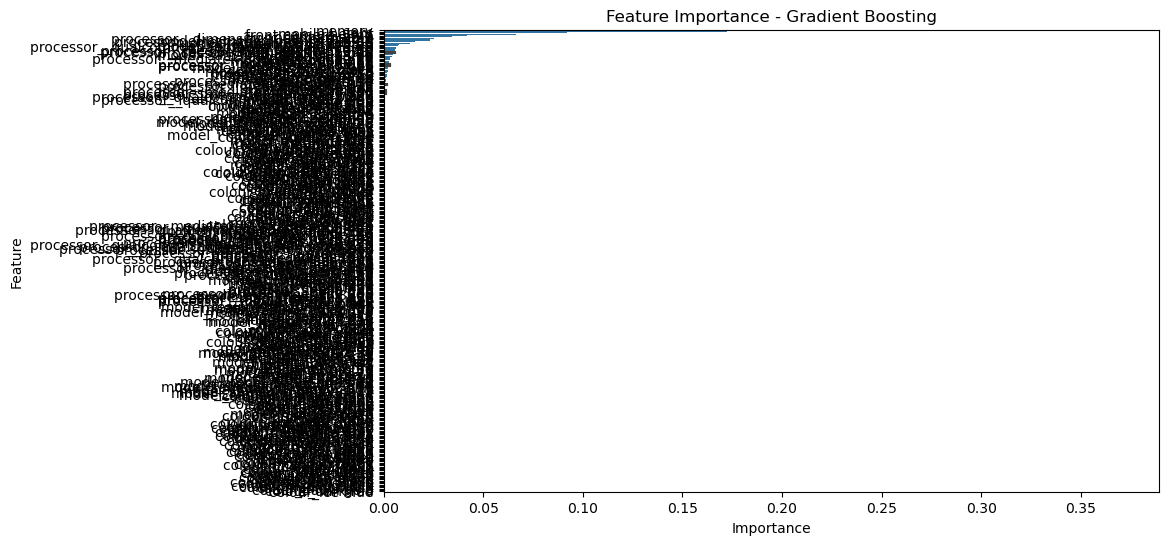

In [35]:

# Plot feature importance for models that support it
for name, importances in feature_importances.items():
    plt.figure(figsize=(10, 6))
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f"Feature Importance - {name}")
    plt.show()
    